# Example of Multidimensional Scaling used for predicting city positions based on intercity distances.

Multidimensional scaling (MDS) is a means of visualizing the level of similarity of individual cases of a dataset. 
MDS is used to translate "information about the pairwise 'distances' among a set of n objects or individuals" into 
a configuration of n points mapped into an abstract Cartesian space.[1]

In this script, we use a dataset of latitudes and longitudes of north american cities to compute the great-circle 
distance between any of them on the Earth. Those distances are closer to flight distances than driving distances 
which are subject to geographic and terrain constraints. Next, we use MDS to predict the city positions individually 
and assess the effect of Earth's curvature on the results. 

[1] Mead, A (1992). "Review of the Development of Multidimensional Scaling Methods". Journal of the Royal 
Statistical Society. Series D (The Statistician). 41 (1): 27–39. JSTOR 234863

In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from math import cos, asin, sqrt, pi

import seaborn as sns
sns.set(color_codes=True)

# Used for reproductibility of the results
np.random.seed(43)

Automatically created module for IPython interactive environment


## Read the dataset

The file "sgb128_dms.txt" contains the longitudes and the latitudes of 128 US and canadian cities.

It can be downloaded from the CITIES dataset directory which contains files with various intercity distances:
https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html
    

In [2]:
file = open("sgb128_dms.txt", "r")
list = file.readlines()
file.close()

# Skip the header
list = list[7:]

# Remove empty spaces
list2 = []
for line in list:
    list2.extend(line.split())

# Remove North and West symbols for longitude
list2 = [list2[i] for i, j in enumerate(list2) if not (j == 'W' or j=='N')]

# Reshape into an 128 x 6 array (Latitude, Longitude in degrees, minutes, seconds)
P = np.array(list2).reshape((128,6))
P = P.astype(np.float32)

# Convert latitude and longitude into degrees
lat = P[:,0] + P[:,1]/60. + P[:,2]/3600.
long = P[:,3] + P[:,4]/60. + P[:,5]/3600.

# Convert latitude and longitude into radians
deg_to_rad = pi/180
lat = lat * deg_to_rad
long = long * deg_to_rad

## Compute the intercity distances (in km) based on their latitudes and longitudes 

The following function computes the great-circle distance between two points on a sphere given their longitudes and latitudes. 
This is the minimum distance between each city and not the actual driving distance. 

The distance is computed using the Haversine formula. More information can be found at https://en.wikipedia.org/wiki/Haversine_formula


In [3]:
def distance(lat1, long1, lat2, long2, R):
    return 2*R*asin(sqrt( hav(lat2-lat1) + cos(lat1)*cos(lat2)*hav(long2-long1) )) 

def hav(theta):
    return (1.-cos(theta))/2

## Compute the distance matrix

In [4]:
# Earth radius in km.  Use R = 3960 to get the distances in miles
R = 6370  
D_sph = np.zeros((128, 128))
for i in range(128):
    for j in range(i+1,128):
        D_sph[i,j] = distance(lat[i], long[i], lat[j], long[j], R)
        D_sph[j,i] = D_sph[i,j] 


print('\nMinimum distance: %d km' % np.min(D_sph[D_sph>1]))
print('Maximum distance: %d km' % np.max(D_sph))


Minimum distance: 33 km
Maximum distance: 4442 km


## Apply MDS to the distance matrix to get city coordinates in 10 dimensions

Now that we have the distance matrix, we can use multidimensional scaling to generate 
the individual city positions. In many MDS applications, we do not know the number of 
underlying dimensions of the data X. All we know are the dissimilarities between them. 

In this script, the X data are the city positions and the dissimilarities are the intercity distances. 
We expect the number of latent (hidden) dimensions to be 2 or 3. In what follows, we will 
use a larger number of dimensions and then rely on PCA to tell us what the true number is.

In [5]:
embedding = MDS(n_components=10, metric=True, dissimilarity='precomputed')
X = embedding.fit_transform(D_sph)

# The X data is an array of 128 x 10  (128 cities and 10 dimensions)
print(X.shape)

(128, 10)


## PCA transformation

In [6]:
# Normalise the data
sc = StandardScaler().fit(X)
X_s = sc.transform(X)

pca = PCA()
pca.fit(X_s);


### Print the scree plot

The first two eigenvalues stand out but a third one is just above the baseline. Hence, even though the X 
data lies in 3-D, the third dimension has a negligible effect in the analysis. Although the cities stand on 
the 3-D surface of the Earth, their north american distribution stretches over a small area on the Earth surface. 
The local curvature effects are small and the city positions are almost in 2D. Airline pilots can see Earth curvature 
but, as far as land distances are concerned, the curvature effect can be neglected as a first approximation.


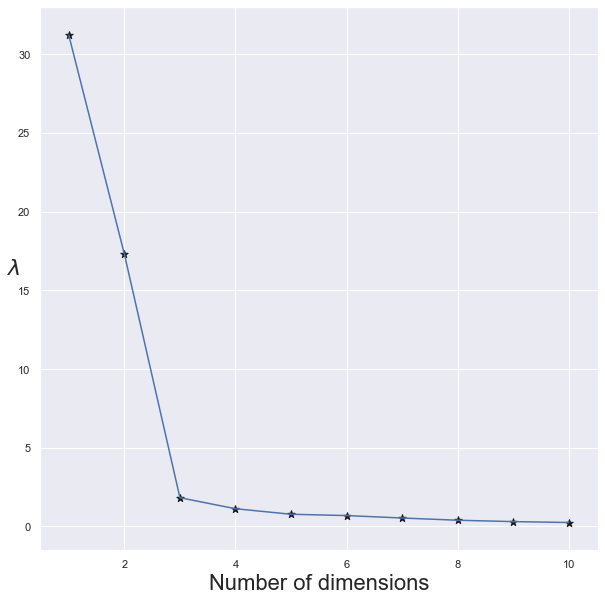

In [7]:
n = np.arange(1,11)
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(n, pca.singular_values_)
ax.scatter(n, pca.singular_values_, c = 'k', marker = '*', s=60)
ax.set_xlabel('Number of dimensions', fontsize=22)
ax.set_ylabel('$\lambda$', fontsize=22, rotation=0)

plt.savefig('13.4.1_Scree_plot_for_city_distances.png')
plt.savefig('13.4.1_Scree_plot_for_city_distances.pdf')

### Keep the first two principal components

Let us compute the PCA transform of the X data and keep only the first two principal components.

In [8]:
# Principal component analysis with only 2 components
clf = PCA(n_components=2)
Z = clf.fit_transform(X_s)

# The sign of each principal component is arbitrary. They remain uncorrelated if their signs are changed.
# We change their signs to generate a figure with the proper orientation.
Z = -Z


## Display the city positions using principal components

The point distribution in the next figure shows very well the outline of the mainland USA. The three yellow dots 
correpond to the canadian cities of Vancouver, Winnipeg and Toronto from left to right (west to east). They are 
located above latitude $49^{o}$. 

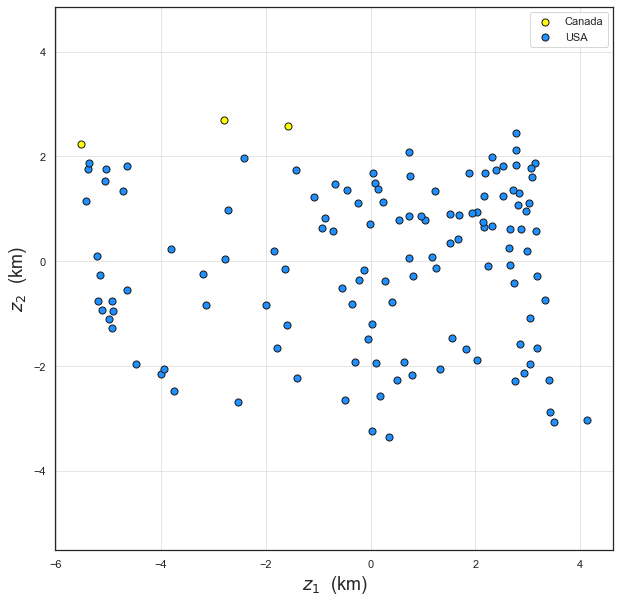

In [9]:
# Identify canadian cities. 
canada = lat>=49*deg_to_rad
usa = lat<49*deg_to_rad

sns.set_style('white')
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(Z[canada,0],Z[canada,1], c='yellow', s=50, edgecolors='k', label='Canada')
ax.scatter(Z[usa,0],Z[usa,1], c='dodgerblue', s=50, edgecolors='k', label='USA')
ax.set_xlabel('$z_{1}$  (km)', fontsize=18)
ax.set_ylabel('$z_{2}$  (km)', fontsize=18)
ax.legend()
ax.axis('equal')
ax.grid(alpha=0.5)

plt.savefig('13.4.2_City_positions_from_MDS.png')
plt.savefig('13.4.2_City_positions_from_MDS.pdf')